# Dy164 uncertainty propagation


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [1]:
%load_ext autoreload


import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.insert(0,"../../")
import oslo_method_python as om
import copy
%autoreload 2


import matplotlib as mpl
#mpl.style.use('article')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('errorbar', capsize=1.5) # Set error bar style


%matplotlib notebook


/home/fabiobz/miniconda3/envs/myenv/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fabiobz/miniconda3/envs/myenv/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


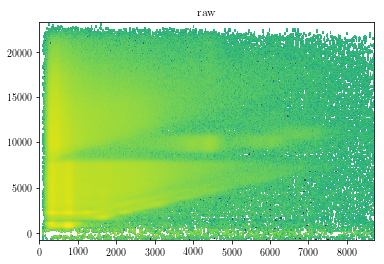

In [2]:
# Import raw matrix into instance of om.Matrix() and plot it
fname_raw = "data/alfna"
raw = om.Matrix()
raw.load(fname_raw)
raw.plot(title="raw", zscale="log")

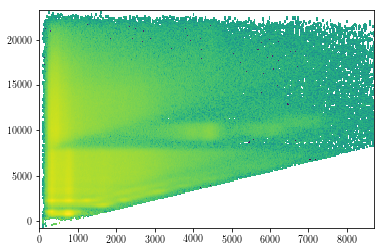

In [3]:
# Cut away diagonal
Ex1 = 0
Eg1 = 800
E1 = [Ex1, Eg1]
Ex2 = 7300
Eg2 = 7800
E2 = [Ex2, Eg2]
#raw_diagcut = copy.copy(raw)
#raw_diagcut.matrix = om.cut_diagonal(raw.matrix, raw.E0_array, raw.E1_array, E1, E2)
raw.cut_diagonal(E1, E2)
raw.plot(zscale="log")

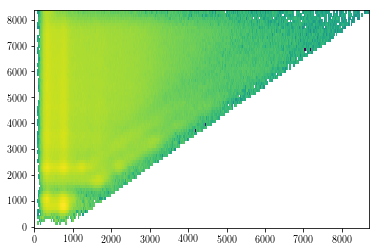

In [4]:
# Drop Ex larger than Sn, about 8300 keV
raw.cut_rect(axis=0, E_limits=[0, 8400])
raw.plot()

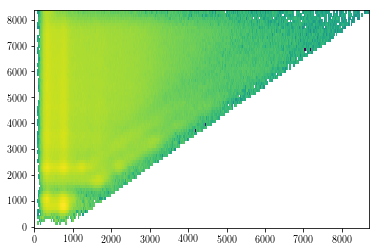

In [5]:
# Put it into an instance of om.MatrixAnalysis() to do unfolding and first generation method:
ma = om.MatrixAnalysis()
ma.raw = raw
ma.raw.plot()

Hello from the fill_negative() function. Please debug me.


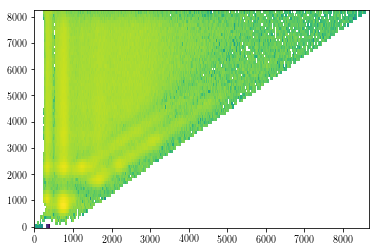

In [6]:
# Unfold the matrix. 
# I haven't implemented a fast enough routine for response function interpolation yet,
# so we have to load response functions with the right calibration, made by MAMA, from file.
fname_resp_mat = "data/response_matrix.m"
fname_resp_dat = "data/resp.dat"

# Call the unfolding algorithm:
diag_cut = {"Ex1": 0, "Eg1": 800, "Ex2": 7300, "Eg2": 7800}
ma.unfold(fname_resp_dat=fname_resp_dat, fname_resp_mat=fname_resp_mat, diag_cut=diag_cut,
          fill_and_remove_negative=True)
# The result is stored in the Matrix() instance ma.unfolded. Plot it:
ma.unfolded.plot()

Hello from the fill_negative() function. Please debug me.


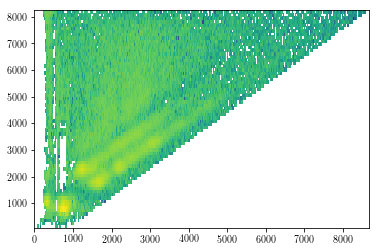

In [7]:
# Run first generation method
ma.first_generation_method(Ex_max = 8500, dE_gamma = 500,
                           fill_and_remove_negative=True)
ma.firstgen.plot(zmin=1e-3)

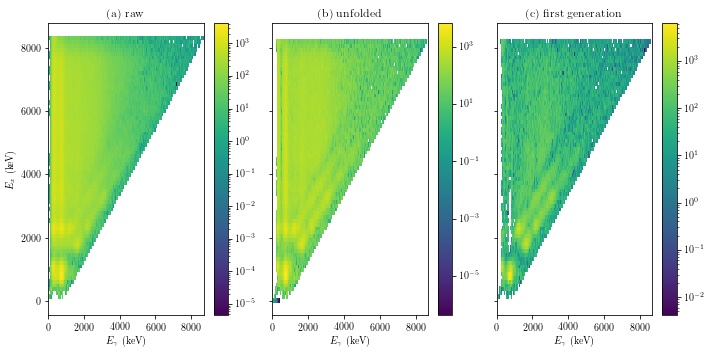

In [8]:
# Plot them all together

f, (axraw, axunf, axfg) = plt.subplots(1, 3, sharey=True)

# Plot raw:
cbar_raw = ma.raw.plot(ax=axraw)
f.colorbar(cbar_raw, ax=axraw)

# Plot unfolded:
cbar_unf = ma.unfolded.plot(ax=axunf)
f.colorbar(cbar_unf, ax=axunf)

# Plot firstgen:
cbar_fg = ma.firstgen.plot(ax=axfg)
f.colorbar(cbar_fg, ax=axfg)


# Add axis labels and titles
axraw.set_title("(a) raw")
axunf.set_title("(b) unfolded")
axfg.set_title("(c) first generation")

axraw.set_ylabel(r"$E_x \,\,\mathrm{(keV)}$")

axraw.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axunf.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axfg.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")



f.set_size_inches((10, 5))
plt.tight_layout(True)


plt.savefig("Dy164-matrices_raw_unf_fg.pdf")

plt.show()

In [9]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
N_ensemble = 40
ep = om.ErrorPropagation(ma, folder="error_propagation_ensemble", random_seed=481516)
ep.generate_ensemble(N_ensemble_members=N_ensemble, randomness="poisson", purge_files=False)

=== Begin ensemble member  0  ===
Read raw matrix from file
Read unfolded matrix from file
Read first generation matrix from file
=== Begin ensemble member  1  ===
Read raw matrix from file
Read unfolded matrix from file
Read first generation matrix from file
=== Begin ensemble member  2  ===
Read raw matrix from file
Read unfolded matrix from file
Read first generation matrix from file
=== Begin ensemble member  3  ===
Read raw matrix from file
Read unfolded matrix from file
Read first generation matrix from file
=== Begin ensemble member  4  ===
Read raw matrix from file
Read unfolded matrix from file
Read first generation matrix from file
=== Begin ensemble member  5  ===
Read raw matrix from file
Read unfolded matrix from file
Read first generation matrix from file
=== Begin ensemble member  6  ===
Read raw matrix from file
Read unfolded matrix from file
Read first generation matrix from file
=== Begin ensemble member  7  ===
Read raw matrix from file
Read unfolded matrix from file

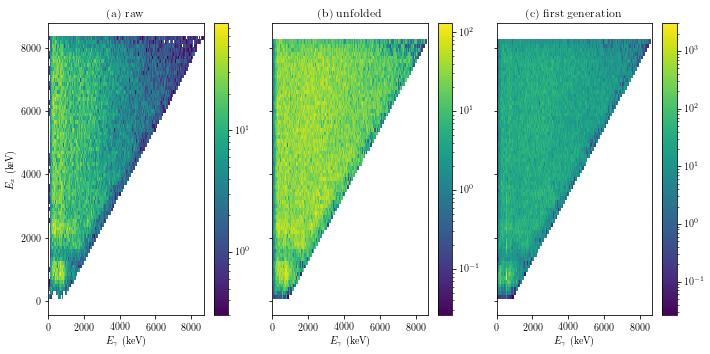

In [10]:
f, (axraw, axunf, axfg) = plt.subplots(1, 3, sharey=True)

# Fetch and plot the standard deviation of raw:
std_raw = ep.std_raw
cbar_raw = std_raw.plot(ax=axraw)
f.colorbar(cbar_raw, ax=axraw)

# Fetch and plot the standard deviation of unfolded:
std_unfolded = ep.std_unfolded
cbar_unf = std_unfolded.plot(ax=axunf)
f.colorbar(cbar_unf, ax=axunf)

# Fetch and plot the standard deviation of firstgen:
std_firstgen = ep.std_firstgen
cbar_fg = std_firstgen.plot(ax=axfg)
f.colorbar(cbar_fg, ax=axfg)


# Add axis labels and titles
axraw.set_title("(a) raw")
axunf.set_title("(b) unfolded")
axfg.set_title("(c) first generation")

axraw.set_ylabel(r"$E_x \,\,\mathrm{(keV)}$")

axraw.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axunf.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axfg.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")



f.set_size_inches((10, 5))
plt.tight_layout(True)


plt.savefig("Dy164-matrices_std_raw_unf_fg.pdf")

plt.show()

# Fit rho and T

attempt decomposition


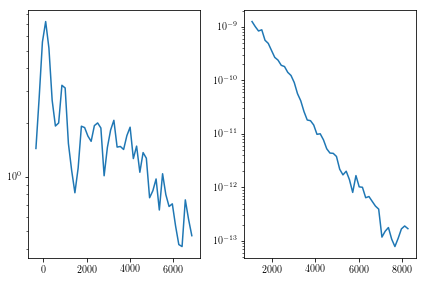

In [11]:

bin_width_out = 150
Ex_min = 4000
Ex_max = 8000
Eg_min = 1000

ftol = 1e-4 # Fitting tolerance (in some unknown, relative units)
maxfev = 9000 # maximum number of function evaluations

#rho, T = om.fit_rho_T(ma.firstgen, firstgen_std, bin_width_out,
fits = om.FitRhoT(ma.firstgen, std_firstgen, bin_width_out,
                      Ex_min, Ex_max, Eg_min,
                      method="Powell",
                      options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                      #error_normalization="approximate"
                     )
rho = fits.rho
T = fits.T

# 20190228: There does not seem to be any speedup from using the approximate normalization.

f, (axrho, axgsf) = plt.subplots(1,2)
rho.plot(ax=axrho, yscale="log")
#T.plot(ax=axT, yscale="log")
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, T.E_array**3))
gsf.plot(ax=axgsf, yscale="log")

plt.tight_layout(True)
plt.show()


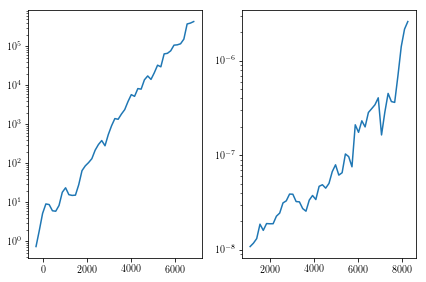

In [12]:
# Play with alpha parameter
alpha = 0.002

f, (axrho, axgsf) = plt.subplots(1,2)
rho.transform(alpha=alpha, inplace=False).plot(ax=axrho, yscale="log")
#T.plot(ax=axT, yscale="log")
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, T.E_array**3))
gsf.transform(alpha=alpha, inplace=False).plot(ax=axgsf, yscale="log")

plt.tight_layout(True)
plt.show()

In [13]:
# Fit the whole error ensemble using their common error matrix; use spread as gauge for uncert
# We replace the firstgen matrix of "ma_curr" every iteration.
ma_curr = copy.deepcopy(ma)

N_ensemble_fit = 40
if N_ensemble_fit > N_ensemble:
    raise ValueError("Not enough ensemble members")

try:
    # Load ensemble members of rho and T fits
    rho_ens = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(N_ensemble_fit))
    T_ens = np.loadtxt("error_propagation_ensemble/T_ensemble_fits-{:d}.txt".format(N_ensemble_fit))
    
except:
    rho_ens = np.zeros((N_ensemble_fit, len(rho.vector)))
    T_ens = np.zeros((N_ensemble_fit, len(T.vector)))
    for i_ens in range(N_ensemble_fit):
        ma_curr.firstgen.matrix = ep.firstgen_ensemble[i_ens, :, :]
        ma_curr.firstgen.matrix[ma_curr.firstgen.matrix < 0] = 0
        #ma.firstgen.plot()
        fits_curr = om.FitRhoT(ma_curr.firstgen, std_firstgen, bin_width_out,
                          Ex_min, Ex_max, Eg_min,
                          method="Powell",
                          options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                         )
        rho_curr= fits_curr.rho
        T_curr = fits_curr.T
        rho_ens[i_ens, :] = rho_curr.vector
        T_ens[i_ens, :] = T_curr.vector
    # Save ensemble members of rho and T fits

    np.savetxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(N_ensemble_fit), rho_ens)
    np.savetxt("error_propagation_ensemble/T_ensemble_fits-{:d}.txt".format(N_ensemble_fit), T_ens)

In [14]:
## for consistency in the plots below, uncomment these lines
## set the vector elements as the mean
# rho.vector = rho_ens.mean(axis=0) # Added by Fabio
# T.vector = T_ens.mean(axis=0) # Added by Fabio

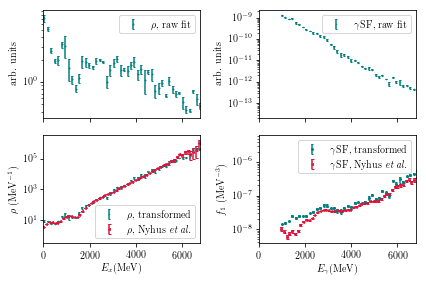

In [15]:
# Plot with uncertainties
alpha=0.002

color="teal"

f, ((axrho_raw, axgsf_raw), (axrho_transf, axgsf_transf)) = plt.subplots(2, 2, sharex=True)

rho_std = om.Vector(vector=np.std(rho_ens, axis=0), E_array=rho.E_array)
axrho_raw.errorbar(rho.E_array, rho.vector, yerr=rho_std.vector,
                   label=r"$\rho$, raw fit", fmt=".", markersize=2, capsize=1, color=color)
#axrho_raw.set_title("rho, raw fit")
axrho_raw.legend()
axrho_raw.set_yscale("log")
axrho_raw.set_xlim([0, rho.E_array.max()])

axrho_transf.errorbar(rho.E_array, rho.transform(alpha=alpha).vector, rho_std.transform(alpha=alpha).vector,
               label=r"$\rho$, transformed", fmt=".", markersize=1, capsize=1, color=color)

# Load and add published, normalized data:
rho_published = np.loadtxt("data/rho164dy.txt", skiprows=2)
rho_published[:, 1] *= 1000
axrho_transf.errorbar(rho_published[:, 1], rho_published[:, 2], yerr=rho_published[:, 3],
                      fmt="<", markersize=2, color="crimson",
                      label=r"$\rho$, Nyhus $\textit{et\,\,al.}$")

#axrho_transf.set_title("rho, transformed")
axrho_transf.legend()
axrho_transf.set_yscale("log")
axrho_transf.set_xlim([0, rho.E_array.max()])

T_std = om.Vector(vector=np.std(T_ens, axis=0), E_array=T.E_array)

# Convert T to gsf
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, T.E_array**3))
gsf_std = om.Vector(E_array=T_std.E_array, vector=om.div0(T_std.vector, T_std.E_array**3))

axgsf_raw.errorbar(gsf.E_array, gsf.vector, yerr=gsf_std.vector,
                   label="$\gamma$SF, raw fit", fmt=".", markersize=1, capsize=1, color=color)
#axgsf_raw.set_title("gsf, raw fit")
axgsf_raw.legend()
axgsf_raw.set_yscale("log")


axgsf_transf.errorbar(gsf.E_array, gsf.transform(const=1.3, alpha=alpha).vector,
                      yerr=gsf_std.transform(alpha=alpha).vector, label=r"$\gamma$SF, transformed",
                      fmt="o", markersize=2, capsize=1, color=color)

# Load and add published, normalized data:
gsf_published = np.loadtxt("data/rsf164dy.txt", skiprows=2)
gsf_published[:, 1] *= 1000
axgsf_transf.errorbar(gsf_published[:, 1], gsf_published[:, 2], yerr=gsf_published[:, 3],
                      fmt="<", markersize=2, color="crimson",
                      label=r"$\gamma$SF, Nyhus $\textit{et\,\,al.}$")

#axgsf_transf.set_title("gsf, transformed")
axgsf_transf.legend()
axgsf_transf.set_yscale("log")

# Axis labels
axrho_raw.set_ylabel("arb. units")
axgsf_raw.set_ylabel("arb. units")

axrho_transf.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
axgsf_transf.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

axrho_transf.set_xlabel(r"$E_x (\mathrm{MeV})$")
axgsf_transf.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

plt.tight_layout(True)

f.savefig("Dy164_rho_and_T_fit_and_alpha_transform.pdf")

plt.show()

In [16]:
# Test if the chisquare is truly invariant to scaling of rho and T, since it looks like the raw fit
# was pretty spot on. Can it be just a coincidence?
from uncertainties import unumpy

"""
# Make cuts to matrices and get middle-bin arrays
pars_fg = {"Egmin" : Eg_min,
           "Exmin" : Ex_min,
           "Emax" : Ex_max}

calib_out = {"a0": -500, "a1": bin_width_out}
# Set up the energy array common to rho and T
E_array = om.E_array_from_calibration(a0=calib_out["a0"],
                                       a1=calib_out["a1"],
                                       E_max=Ex_max)
E_array_midbin = E_array + calib_out["a1"]/2

firstgen_matrix, Emid_Eg, Emid_Ex, Emid_nld = om.fg_cut_matrix(ma.firstgen.matrix,
                                                        E_array_midbin, **pars_fg)
firstgen_std_matrix, Emid_Eg, Emid_Ex, Emid_nld = om.fg_cut_matrix(std_firstgen.matrix,
                                                        E_array_midbin, **pars_fg)


# Normalize P_exp
u_oslo_matrix = unumpy.uarray(firstgen_matrix, firstgen_std_matrix)

# normalize each Ex row to 1 (-> get decay probability)
for i, normalization in enumerate(np.sum(u_oslo_matrix,axis=1)):
    try:
        u_oslo_matrix[i,:] /= normalization
    except ZeroDivisionError:
        u_oslo_matrix[i,:]=0
P_in = unumpy.nominal_values(u_oslo_matrix)
P_err = unumpy.std_devs(u_oslo_matrix)

dE_resolution = fits.dE_resolution
print(P_in.shape, T.vector.shape)
"""
P_in = fits.firstgen.matrix
P_err = fits.firstgen_std.matrix

Emid_Ex = fits.firstgen.E0_array + bin_width_out/2
Emid_Eg = fits.firstgen.E1_array + bin_width_out/2
Emid_nld = rho.E_array
dE_resolution = fits.dE_resolution

chisq_orig = om.chi2(rho.vector, T.vector, P_in, P_err, Emid_Eg, Emid_Ex, Emid_nld, dE_resolution)
chisq_A = om.chi2(2*rho.vector, T.vector, P_in, P_err, Emid_Eg, Emid_Ex, Emid_nld, dE_resolution)
chisq_B = om.chi2(rho.vector, 0.001*T.vector, P_in, P_err, Emid_Eg, Emid_Ex, Emid_nld, dE_resolution)
alpha = 0.002
chisq_alpha = om.chi2(rho.transform(alpha=alpha).vector, T.transform(alpha=alpha).vector, P_in, P_err, Emid_Eg, Emid_Ex, Emid_nld, dE_resolution)

print("chisq's =", chisq_orig, chisq_A, chisq_B, chisq_alpha)

chisq's = 40826596.0 40826596.0 40826596.0 40824880.0


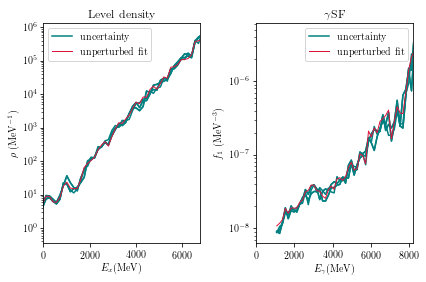

In [17]:
# Plot rho and gsf ensembles

f, (axrho, axgsf) = plt.subplots(1, 2)

opacity = 1# 0.2

# rho
rho_E_array_midbin = rho.E_array + rho.calibration()["a1"]/2
for i_ens in range(len(rho_ens[:, 0])):
    label = "uncertainty" if i_ens == 0 else None
    axrho.plot(rho_E_array_midbin, rho_ens[i_ens, :]*np.exp(alpha*rho_E_array_midbin), alpha=opacity,
               color="teal", label=label)
rho.transform(alpha=alpha).plot(ax=axrho, color="crimson", linewidth=1, label="unperturbed fit")

axrho.legend()
axrho.set_yscale("log")
axrho.set_xlim([0, rho.E_array.max()])
axrho.set_title("Level density")

# gsf
gsf_E_array_midbin = gsf.E_array + gsf.calibration()["a1"]/2
for i_ens in range(len(T_ens[:, 0])):
    label = "uncertainty" if i_ens == 0 else None
    axgsf.plot(gsf_E_array_midbin, T_ens[i_ens, :]*np.exp(alpha*gsf_E_array_midbin)/gsf_E_array_midbin**3,
               alpha=opacity, color="teal", label=label)
gsf.transform(alpha=alpha).plot(ax=axgsf, color="crimson", linewidth=1, label="unperturbed fit")

axgsf.legend()
axgsf.set_yscale("log")
axgsf.set_xlim([0, gsf.E_array.max()])
#axgsf.set_ylim([1e-10, 3e-9])
axgsf.set_title(r"$\gamma$SF")


# Axis labels
axrho.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
axgsf.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")
axrho.set_xlabel(r"$E_x (\mathrm{MeV})$")
axgsf.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

plt.tight_layout(True)
f.savefig("Dy164_fit_rho_gsf_transformed_with_uncertainty_band.pdf")

plt.show()